##Application & Tips
Learning rate
- Gradient
- Good and Bad Learning rate
- Annealing the learning rate (Decay)

Data preprocessing
- Standardization(표준화기법) / Normalization(정규화기법)
- Noisy Data

Overfitting
- Regularization
- L2 Norm

##overfitting Solution
- Feature Normalization
- Regularization
- More Data (Data Augmentation) : 데이터 증가
1. Color Jilttering : (이미지의 경우) 다양한 색상 추가
2. Horizontal Flips : 이미지 뒤집기
3. Random Crops/Scales : 적당한 크기로 자르든가 이미지 사이즈 크게하기
- **Dropout**
- Batch Normalization



기본 Library 선언 및 Tensorflow 버전확인

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777) # for reproducibility

print(tf.__version__)

2.5.0


정규화를 위한 함수 (최대, 최소값이 1과 0이 되도록 Scaling한다.)

In [ ]:
def normalization(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  return numerator / denominator

X data(feature)의 값은 해당 배열의 첫번재 값부터 4번째 값까지로 정의되고 </br>
Y data(label)는 해당 배열의 마지막 값을 정의한다. (5번째 값)

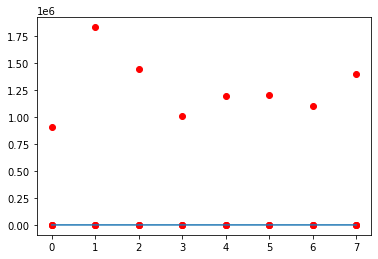

In [ ]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

data에 표준화를 적용

[[1.         1.         0.         1.         1.        ]
 [0.70548491 0.70439552 1.         0.71881783 0.83755792]
 [0.54412549 0.50274824 0.57608696 0.60646801 0.6606331 ]
 [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
 [0.51436    0.4258239  0.30434783 0.58504805 0.42624401]
 [0.49556179 0.4258239  0.31521739 0.48131134 0.49276137]
 [0.11436064 0.         0.20652174 0.22007776 0.18597238]
 [0.         0.07747099 0.5326087  0.         0.        ]]


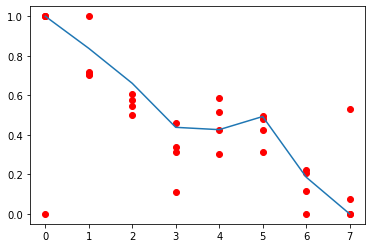

In [ ]:
xy = normalization(xy)
print(xy)

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

Tensorflow data API를 통해 학습시킬 값들을 담는다. (Batch size는 한번에 학습시킬 size로 정한다.)</br>
X(features), y(labels)는 실제 학습에 쓰일 data(연산을 위해 type을 맞춘다.)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

W와 b는 학습을 통해 생성되는 모델에 쓰이는 weight와 bias</br>
(초기값을 variable: 0이나 random 값으로 가능함 : tf.random.normal / tf.zeros)


In [ ]:
W = tf.Variable(tf.random.normal((4,1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

Linear Regression의 hypothesis를 정의한다 (y = Wx + b)

In [ ]:
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

L2_loss를 적용할 함수를 정의
- weight의 수가 많아지면 수만큼 더한다 ( tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3))

In [ ]:
def l2_loss(loss, beta = 0.01):
  W_reg = tf.nn.l2_loss(W) # output = sum(t ** 2) /2
  loss = tf.reduce_mean(loss + W_reg * beta)
  return loss

가설을 검증할 Cost 함수를 정의(Mean Square Error를 사용)

In [ ]:
def loss_fn(hypothesis, features, labels, flag = False):
    cost = tf.reduce_mean(tf.square(hypothesis - labels))
    if(flag):
        cost = l2_loss(cost)
    return cost

## Learning Rate 값을 조정하기 위한 Learning Decay 설정

5개의 파라미터 설정
- starter learning rate: 최초 학습시 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
- global step: 현재 학습 횟수
- 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
- 0.96 : 기존 learning에 곱할 값
- 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
- decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [ ]:
is_decay = True
starter_learning_rate = 0.1

if (is_decay):
  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                 decay_steps=50,
                                                                 decay_rate=0.96,
                                                                 staircase=True)
  optimizer = tf.keras.optimizers.SGD(learning_rate)

else:
  optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)

def grad(hypothesis, feature, labels, l2_flag):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(linearReg_fn(features), features, labels, l2_flag)
  return tape.gradient(loss_value, [W, b]), loss_value

TensorFlow를 통해 학습진행

In [ ]:
epochs = 101

for step in range(epochs):
  for features, labels in dataset:
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    grads, loss_value = grad(linearReg_fn(features), features, labels, False)
    optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b])) 
  if step % 10 == 0:
    print("Iter: {}, Loss: {:.4f}".format(step, loss_value))


Iter: 0, Loss: 0.3866
Iter: 10, Loss: 0.1237
Iter: 20, Loss: 0.0644
Iter: 30, Loss: 0.0343
Iter: 40, Loss: 0.0189
Iter: 50, Loss: 0.0110
Iter: 60, Loss: 0.0071
Iter: 70, Loss: 0.0051
Iter: 80, Loss: 0.0040
Iter: 90, Loss: 0.0035
Iter: 100, Loss: 0.0032
